epoch: 0.27, loss: 221.4336
epoch: 0.53, loss: 205.9687
epoch: 0.80, loss: 196.8050


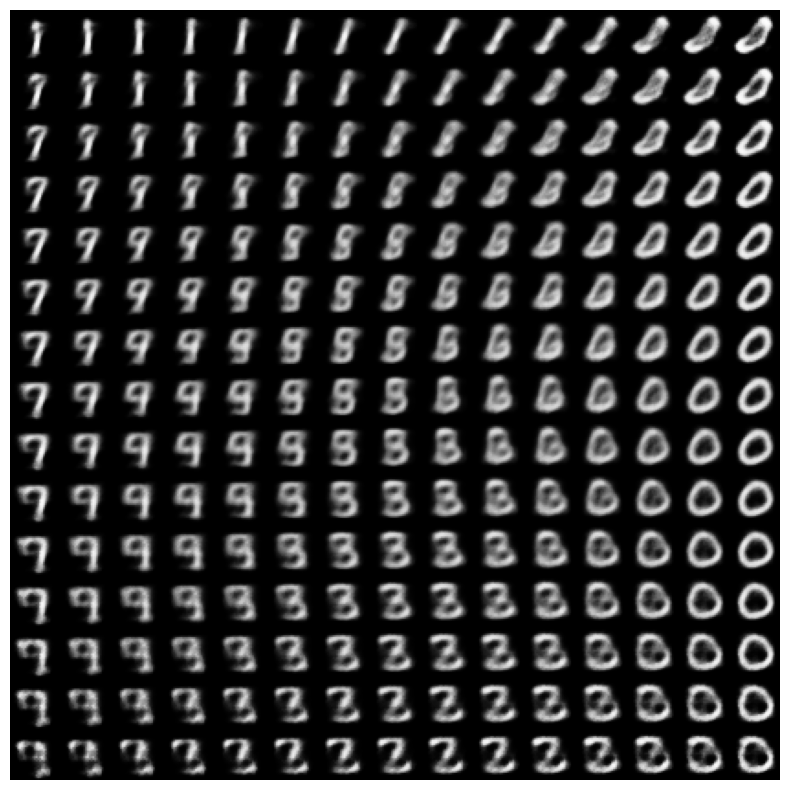

epoch: 1.27, loss: 160.3786
epoch: 1.53, loss: 159.0287
epoch: 1.80, loss: 158.2557


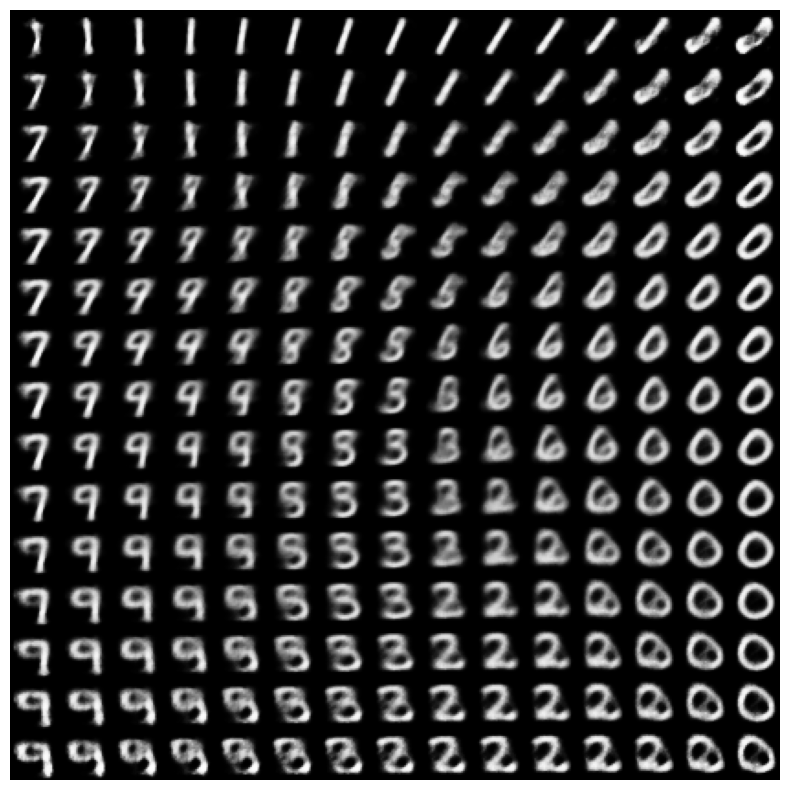

epoch: 2.27, loss: 153.9162
epoch: 2.53, loss: 153.2584
epoch: 2.80, loss: 152.7921


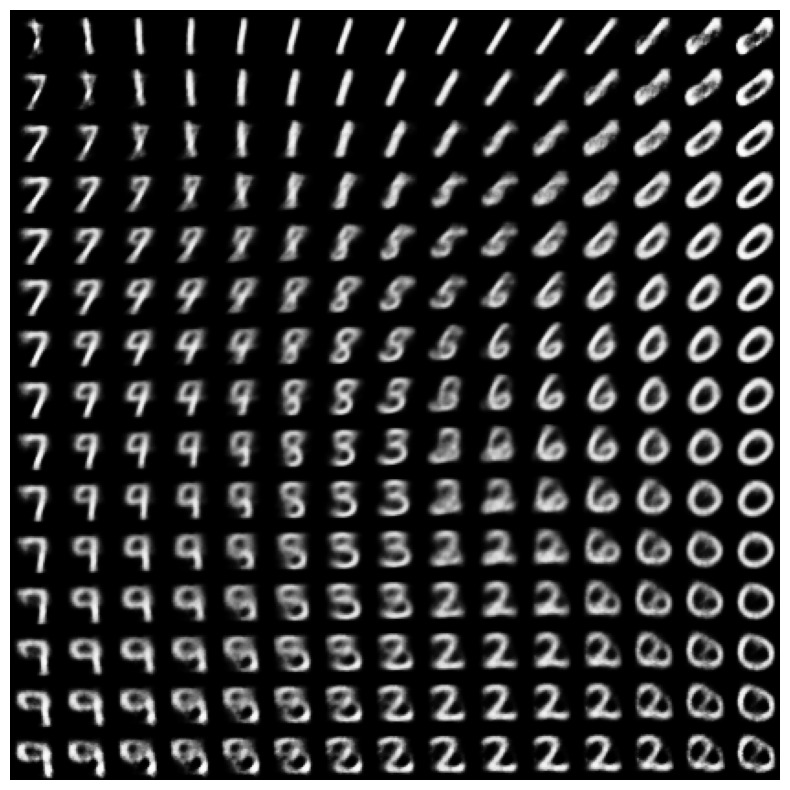

epoch: 3.27, loss: 149.9782
epoch: 3.53, loss: 149.9657
epoch: 3.80, loss: 149.5378


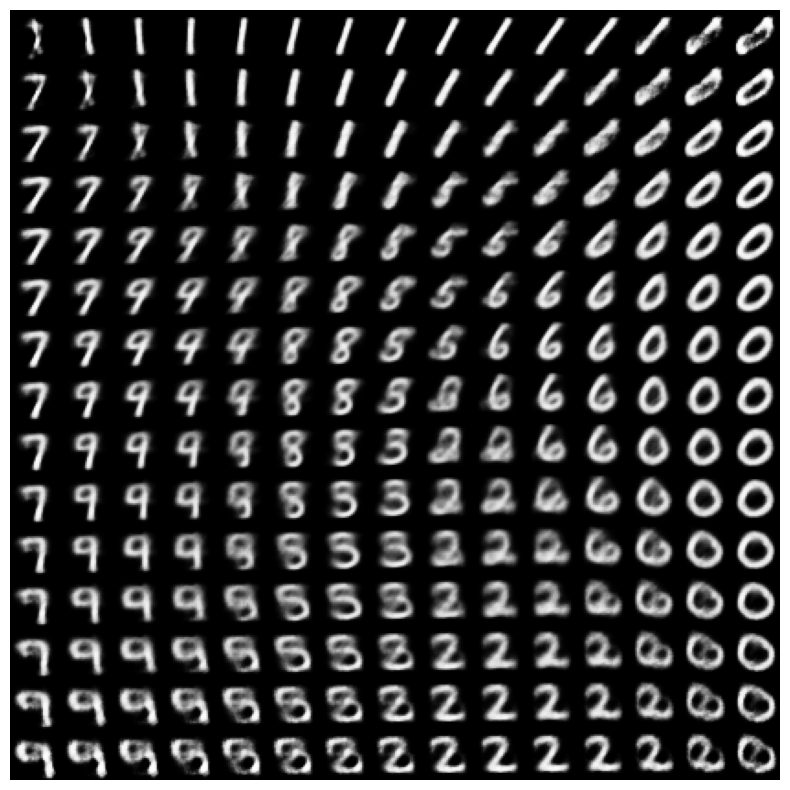

epoch: 4.27, loss: 148.0188
epoch: 4.53, loss: 147.3956
epoch: 4.80, loss: 147.3335


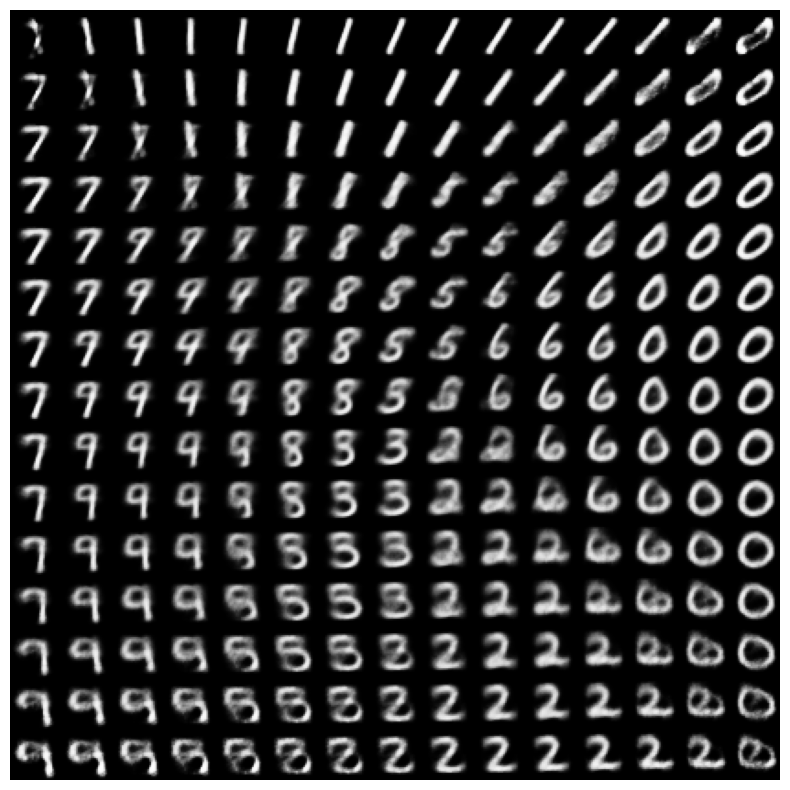

epoch: 5.27, loss: 145.6991
epoch: 5.53, loss: 145.5141
epoch: 5.80, loss: 145.5077


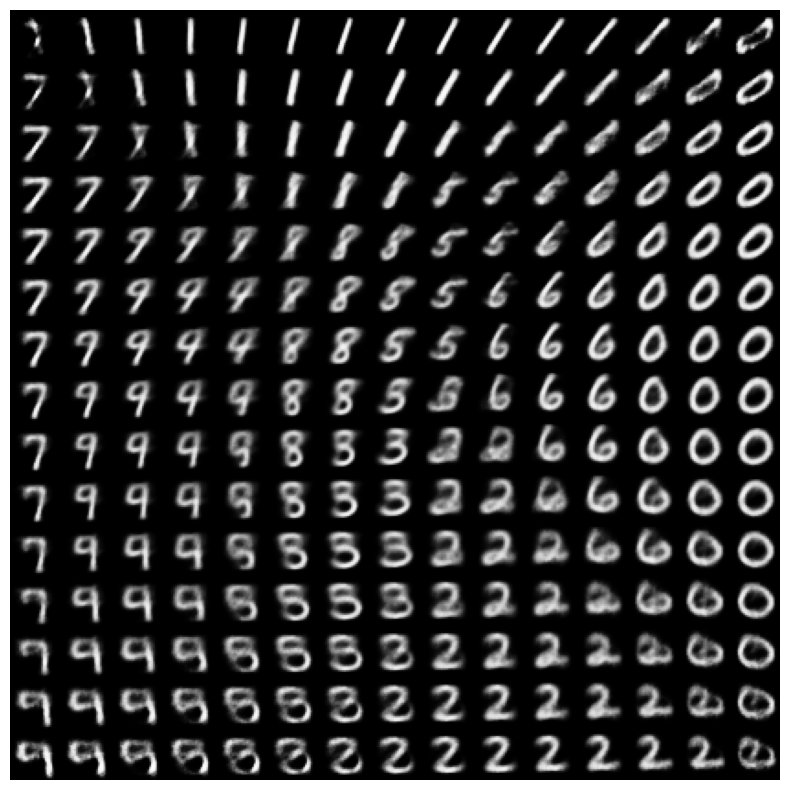

epoch: 6.27, loss: 144.6035
epoch: 6.53, loss: 144.4206
epoch: 6.80, loss: 144.5169


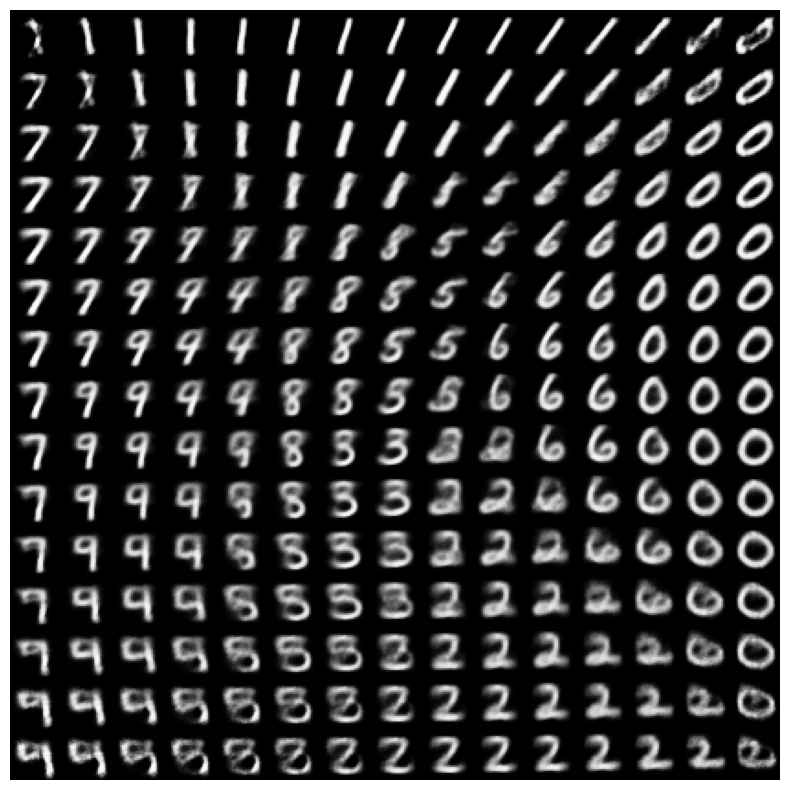

epoch: 7.27, loss: 144.1451
epoch: 7.53, loss: 143.8941
epoch: 7.80, loss: 143.6481


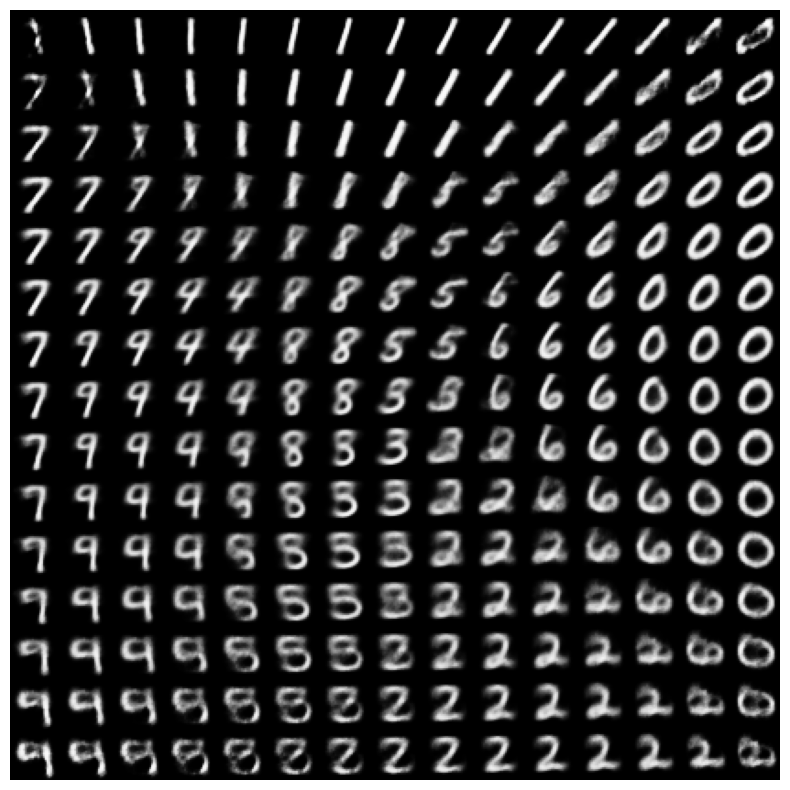

epoch: 8.27, loss: 143.1327
epoch: 8.53, loss: 142.9131
epoch: 8.80, loss: 142.9499


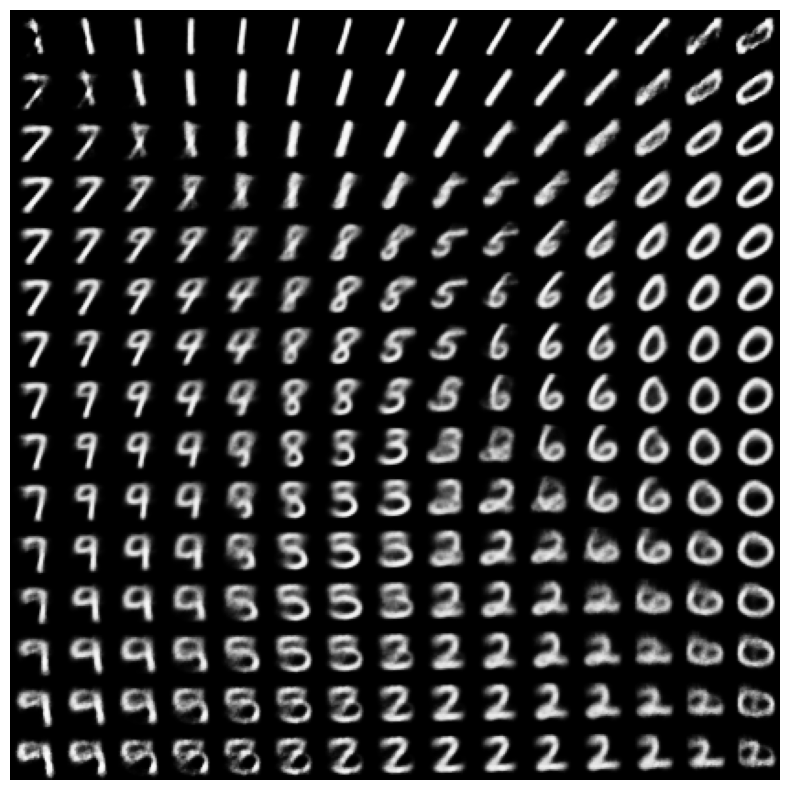

epoch: 9.27, loss: 141.6566
epoch: 9.53, loss: 142.0751
epoch: 9.80, loss: 142.2650


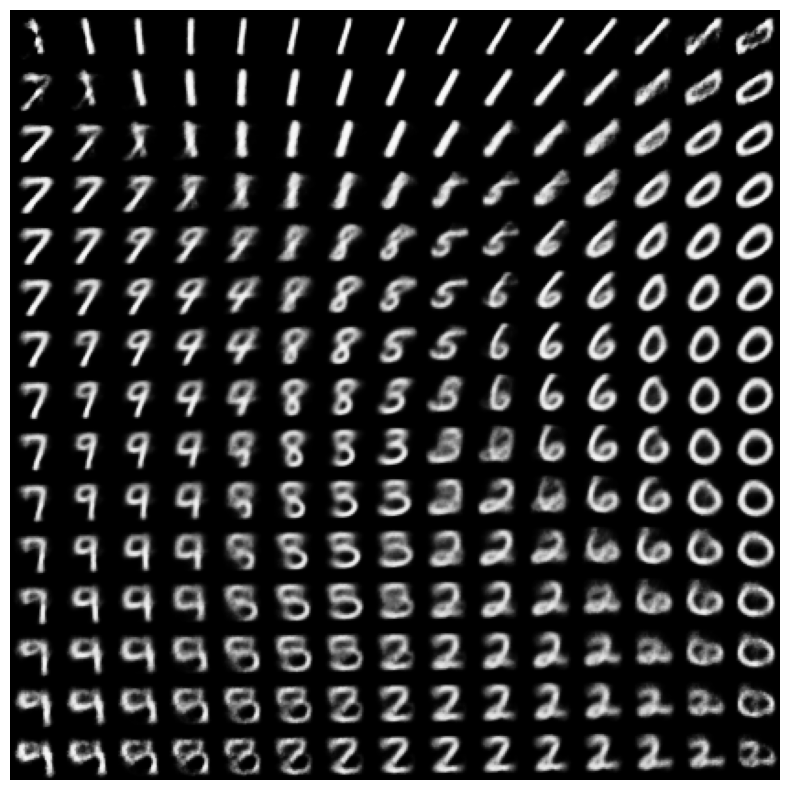

In [3]:
import sys, os
sys.path.append(os.pardir)
sys.path.append(os.curdir)
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import axon
import axon.functions as F
import axon.layers as L
from axon import DataLoader
from axon.models import Model
from axon.optimizers import Adam

use_gpu = axon.core.gpu_enable
max_epoch = 10
batch_size = 16
latent_size = 2 # 潜在空间维度

# 编码器
class Encoder(Model):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        self.conv1 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.conv2 = L.Conv2d(64, kernel_size=3, stride=2, pad=1)
        self.conv3 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv4 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.linear1 = L.Linear(32)
        self.linear2 = L.Linear(latent_size)
        self.linear3 = L.Linear(latent_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.flatten(x)
        x = F.relu(self.linear1(x))
        z_mean = self.linear2(x)
        z_log_var = self.linear3(x)
        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        batch_size = len(z_mean)
        xp = axon.core.get_array_module(z_mean.data)
        epsilon = xp.random.randn(batch_size, self.latent_size)
        return z_mean + F.exp(z_log_var) * epsilon

# 解码器
class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.to_shape = (64, 14, 14)  # (C, H, W)
        self.linear = L.Linear(np.prod(self.to_shape)) 
        self.deconv = L.Deconv2d(32, kernel_size=4, stride=2, pad=1)
        self.conv = L.Conv2d(1, kernel_size=3, stride=1, pad=1)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.reshape(x, (-1,) + self.to_shape)  # reshape to (-1, C, H, W)
        x = F.relu(self.deconv(x))
        x = self.conv(x)
        x = F.sigmoid(x)
        return x

# https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
# 变分自编码器
class VAE(Model):
    def __init__(self, latent_size):
        super().__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder()

    def forward(self, x, C=1.0, k=1):
        """Call loss function of VAE.
        The loss value is equal to ELBO (Evidence Lower Bound)
        multiplied by -1.

        Args:
            x (Variable or ndarray): Input variable.
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
        """
        z_mean, z_log_var = self.encoder(x)

        rec_loss = 0 # 重构损失
        for l in range(k):
            z = self.encoder.sampling(z_mean, z_log_var)
            y = self.decoder(z)
            rec_loss += F.binary_cross_entropy(F.flatten(y), F.flatten(x)) / k

        kl_loss = C * (z_mean ** 2 + F.exp(z_log_var) - z_log_var - 1) * 0.5 # KL散度
        kl_loss = F.sum(kl_loss) / len(x)
        return rec_loss + kl_loss

def show_digits(epoch=0):
    """Display a 2D manifold of the digits"""
    n = 15  # 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # 观察潜在空间的分布
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            if use_gpu:
                z_sample = axon.core.as_cupy(z_sample)
            with axon.no_grad():
                x_decoded = vae.decoder(z_sample)
            if use_gpu:
                x_decoded.data = axon.core.as_numpy(x_decoded.data)
            digit = x_decoded.data.reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

vae = VAE(latent_size)
optimizer = Adam().setup(vae)

transform = lambda x: (x / 255.0).astype(np.float32)
train_set = axon.datasets.MNIST(train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size)

xp = axon.core.cupy if use_gpu else np
for epoch in range(max_epoch):
    avg_loss = 0
    cnt = 0

    for x, t in train_loader:
        cnt += 1

        loss = vae(x)
        vae.cleargrads()
        loss.backward()
        optimizer.update()

        avg_loss += loss.data
        interval = 1000 if use_gpu else 10
        if cnt % interval == 0:
            epoch_detail = epoch + cnt / train_loader.max_iter
            print('epoch: {:.2f}, loss: {:.4f}'.format(epoch_detail,
                                                       float(avg_loss/cnt)))

    show_digits(epoch)